Digital Business University of Applied Sciences

Data Science und Management (M. Sc.)

FAIN93 SP IV Modul 3: Forschungsprojekt Artificial Intelligence

Claudia Baldermann

Julia Schmid (200022)

***
## Identifikation von intersektionalem Repräsentationsbias in Textdaten
***

In diesem Jupyter-Notebook werden quantitative Methoden zur Identifizierung von intersektionalem Repräsentationbias auf die Bildbeschriftungen des Flickr 8k Datensatz vom Kaggle (Aditya, 2020) angewendet und miteinander verglichen.

### **Import der benötigten Pakete**

In [1]:
# Imports
import certifi
import gensim.downloader as api
import kagglehub
import math
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import scipy.stats as stats
import seaborn as sns
import shutil
import spacy
import ssl
import string

from collections import Counter
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from openpyxl import Workbook
from transformers import pipeline
from wefe.metrics import WEAT
from wefe.query import Query
from wefe.word_embedding_model import WordEmbeddingModel
from wordcloud import WordCloud

### **Einlesen der Daten**

Im Datensatz sind sowohl Bilddaten als auch die zugehörigen Beschreibungen enthalten. Für die weitere Verarbeitung werden nur die Bildbeschreibungen benötigt.

In [2]:
# Daten Downloadpfad
path = kagglehub.dataset_download("adityajn105/flickr8k")

# Textdatei in das Zielverzeichnis kopieren
target_dir = "./"
os.makedirs(target_dir, exist_ok=True) # Zielverzeichnig erstellen (falls dieses noch nicht existiert)
for filename in os.listdir(path):
    if filename.endswith(".txt"):
        shutil.copy(os.path.join(path, filename), os.path.join(target_dir, filename))

# Für die Weiterverarbeitung wird die Textdatei als DataFrame gespeichert
df = pd.read_csv('captions.txt', sep=',')

### **Datenaufbereitung**

In [3]:
# Bereinigung 

'''
Funktion:       Bereinigung der Beschriftungen durch das Entfernen von verschiedenen Formatierungszeichen
Input:          caption (Beschriftung)
Output:         caption (bereinigter Beschriftung)
Funktionsweise: Die übergebene Beschriftung wird in Kleinbuchstaben umgewandelt. Anschließend werden Satzzeichen, Zahlen, einzelnen Buchstaben sowie überflüssigen Leerzeichen entfernt.
'''
def clean_caption(caption):
    caption = caption.lower() # Umwandlung in Kleinbuchstaben
    caption = caption.translate(str.maketrans('', '', string.punctuation))  # Entfernung von Satzzeichen
    caption = re.sub(r'\d+', '', caption)  # Entfernung von Zahlen
    caption = re.sub(r'\b\w\b', '', caption)  # Entfernung von einzelne Buchstaben
    caption = re.sub(r'\s+', ' ', caption).strip()  # Entfernung von überflüssigen Leerzeichen
    return caption

# Anwendung der Funktion clean_caption auf die Bildbeschriftungen (captions)
df['clean_caption'] = df['caption'].apply(clean_caption)


# Quelle: Berknology. (2022). Text preprocessing for Natural Language Processing. Abgerufen am 04.07.2025 von https://github.com/berknology/text-preprocessing/blob/master/text preprocessing/text preprocessing.py

In [4]:
# Tokenisierung

'''
Funktion:       Zerlegung der Beschriftungen in Token (einzelne Worte)
Input:          caption (Beschriftung)
Output:         tokens (aufgetrenter Beschriftung)
Funktionsweise: Die übergebende Beschriftung wird in ihre Satzbestandteile in Tokens zerlegt.
'''
def tokenize_caption(caption):
    tokens = word_tokenize(caption)
    return tokens

# Anwendung der Funktion tokenize_caption auf die bereinigten Bildbeschriftungen (clean_caption)
df['clean_caption'] = df['clean_caption'].apply(tokenize_caption)


# Quelle: Berknology. (2022). Text preprocessing for Natural Language Processing. Abgerufen am 04.07.2025 von https://github.com/berknology/text-preprocessing/blob/master/text preprocessing/text preprocessing.py

In [5]:
# Stoppworte entfernen

# Einstellung für das Laden der Stopwörter
ssl._create_default_https_context = lambda: ssl.create_default_context(cafile=certifi.where())

# Laden der Stopwörter
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Alle Stopwörter werden aus den tokenisierten Beschriftungen entfernt
df['clean_caption'] = df['clean_caption'].apply(lambda tokens: [token for token in tokens if token.lower() not in stop_words])


# Quelle: Berknology. (2022). Text preprocessing for Natural Language Processing. Abgerufen am 04.07.2025 von https://github.com/berknology/text-preprocessing/blob/master/text preprocessing/text preprocessing.py

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juliaschmid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Erstellung eines Strings für jede Token-Liste einer Beschriftung
df["clean_caption_string"] = df["clean_caption"].apply(lambda x: " ".join(x)) 

### **Bestimmung geschlechtsbezogenen und ethnischen Begriffe in den Beschriftungen**

In [7]:
list_female_words = [
    "woman", "women", "girl", "girls", 
    "lady", "ladies","mommy", "mother", 
    "daughter", "wife", "girlfriend", "girlfriends", 
    "sister", "sisters", "miss", "mrs",
    "princess", "queen", "widow", "female", 
    "aunt","she", "her"
]

list_male_words = [
    "man", "men", "boy", "boys", 
    "gentleman", "gentlemen","dad", 
    "father", "son", "husband", "boyfriend",
    "boyfriends", "brother", "brothers", "mr", 
    "sir","prince", "king", "widower", 
    "male", "uncle","he", "his"
]

list_black_words = ["black", "african", 
                    "afro","colored", 
                    ]

list_white_words = ["white", "caucasian", 
                     "european",  "western"
                    ]

# Bestimmung der gruppenübergreifenden Wortlisten
list_female_white_words = list_female_words + list_white_words
list_female_black_words = list_female_words + list_black_words
list_male_white_words = list_male_words + list_white_words
list_male_black_words = list_male_words + list_black_words

In [8]:
# Klassifizierung der Beschriftungen

'''
Funktion:       Klassifikation von Beschriftungen auf Grundlage des Vorkommens gruppenspezifischer Begriffe und Zählung dieser Begriffe
Input:          token_caption (Beschriftungs-Token-Liste)
                list_words_1 (Wortliste der ersten Gruppe)
                list_words_2 (Wortliste der zweiten Gruppe)
                label_1 (Label für die ersten Gruppe)
                label_2 (Label für die zweite Gruppe)
Output:         label (Klassenlabel)
Funktionsweise: Es wird in der übergebenden Beschriftungs-Token-Liste gezählt, wie oft ein Wort aus den beiden gruppenspezifischen Wortlisten vorkommen.
                Wird mindestens ein Wort aus beiden Gruppen gefunden, so wird die Beschriftung als "nicht eindeutig" klassifiziert.
                Wird mindestens ein Wort aus nur einem der beiden Gruppen gefunden, so wird die Beschriftung mit dem dazugehörigen Label klassifiziert.
                Wird kein Wort aus den beiden Gruppen gefunden, so wird die Beschriftung mit "none" klassifiziert.
'''
def classify_caption(token_caption, list_words_1, list_words_2, label_1, label_2):
    count_words_1 = sum(token_caption.count(word) for word in list_words_1) # Zählung der Begriffe aus Wortvorkommen Gruppe 1
    count_words_2 = sum(token_caption.count(word) for word in list_words_2) # Zählung der Begriffe aus Wortvorkommen Gruppe 2

    label = "none"
    if count_words_1 >= 1 and count_words_2 >= 1: # Beide Gruppen
        label = "nicht eindeutig"
    elif count_words_1 >= 1: # Nur Gruppe 1
        label = label_1
    elif count_words_2 >= 1: # Nur Gruppe 2
        label = label_2
    else: # Keine Gruppe 
        label = "none"

    return label, count_words_1, count_words_2


# Anwendung der Funktion classify_caption auf die geschlechtsspezifischen Wortgruppen
df[["gender", "count_female", "count_male"]] = df["clean_caption"].apply(lambda x: pd.Series(classify_caption(x, list_female_words, list_male_words, "weiblich", "männlich")))
# Anwendung der Funktion classify_caption auf die ethnischen Wortgruppen
df[["race", "count_black", "count_white"]] = df["clean_caption"].apply(lambda x: pd.Series(classify_caption(x, list_black_words, list_white_words, "schwarz", "weiß")))

# Zusammenführung der beiden Klassen
df['gender_race'] = df['gender'] + ' - ' + df['race']

# Bestimmung der intersektionellen Gruppen
intersectional_groups = [
    ('männlich - schwarz', 'weiblich - weiß'),
    ('männlich - weiß', 'weiblich - weiß'),
    ('männlich - schwarz', 'weiblich - schwarz'),
    ('männlich - weiß', 'weiblich - schwarz')
]

# Gesamtanzahl der Wortvorkommen über alle Wortgruppen pro Beschriftung
df["count_total"] = df["count_female"] + df["count_male"] + df["count_black"] + df["count_white"]
 

In [9]:
# Es werden nur die Kombinationen "weiblich - schwarz", "weiblich - weiß", "männlich - schwarz", "männlich - weiß" betrachtet
df = df[df['gender_race'].isin(['weiblich - schwarz', 'weiblich - weiß', 'männlich - schwarz', 'männlich - weiß'])]

#### **Evaluationsfunktion**

In [10]:
'''
Funktion:       Bestimmung des Cohen's d Wert
Input:          group1 (Daten der Gruppe 1)
                group2 (Daten der Gruppe 1)
Output:         d (Cohen's d Wert)
Funktionsweise: Für die Gruppe 1 und 2 wird jeweils der Mittelwert, die Standardabweichung und die Gruppengröße bestimmt. 
                Basierend auf den Standardabweichungen der beiden Gruppen wird die gesamt Standardabweichung bestimmt.
                Anschließend wird der Cohen's d Wert gemäß der Cohen's d Formel berechnet.
'''
def calculate_cohens_d(group1, group2):
    # Mittelwerte
    mean1 = np.mean(group1)
    mean2 = np.mean(group2)
    # Standardabweichungen
    std1 = np.std(group1, ddof=1)
    std2 = np.std(group2, ddof=1)
    # Gruppengröße
    n1 = len(group1)
    n2 = len(group2)
    # Standardabweichung
    std = np.sqrt(((n1 - 1)*std1**2 + (n2 - 1)*std2**2) / (n1 + n2 - 2))
    if std == 0:
        return 0  # keine Division durch Null
    # Cohen's d
    d = round(abs((mean1 - mean2) / std),3)
    return d

# Definierung eines leeren Ergebnis-DataFrames
df_evaluation = pd.DataFrame(intersectional_groups, columns=['Gruppe 1', 'Gruppe 2'])

#### **Häufigkeitsanalyse**

In [11]:
# Bestimmung der Anzahl der geschlechtsspezifischen und ethnischen Klassifizierungen
race_gender_counts = df['gender_race'].value_counts()
df_race_gender_counts = race_gender_counts.reset_index()
df_race_gender_counts.columns = ['gender_race', 'count']

# Bestimmung der prozentualen Verteilung der geschlechtsspezifischen und ethnischen Klassifizierungen
race_gender_percent = df['gender_race'].value_counts(normalize=True) * 100
df_race_gender_percent = race_gender_percent.reset_index()
df_race_gender_percent.columns = ['gender_race', 'percent']
df_race_gender_percent['percent'] = df_race_gender_percent['percent'].round(2)

df_race_gender = df_race_gender_counts.merge(df_race_gender_percent, on='gender_race')
df_race_gender

,gender_race,count,percent
0,männlich - schwarz,546,30.17
1,männlich - weiß,511,28.23
2,weiblich - weiß,380,20.99
3,weiblich - schwarz,373,20.61


                    weiblich  männlich  schwarz  weiß  count_total
gender_race                                                       
männlich - schwarz         0       585      570     0         1155
männlich - weiß            0       549        0   529         1078
weiblich - schwarz       391         0      387     0          778
weiblich - weiß          404         0        0   390          794


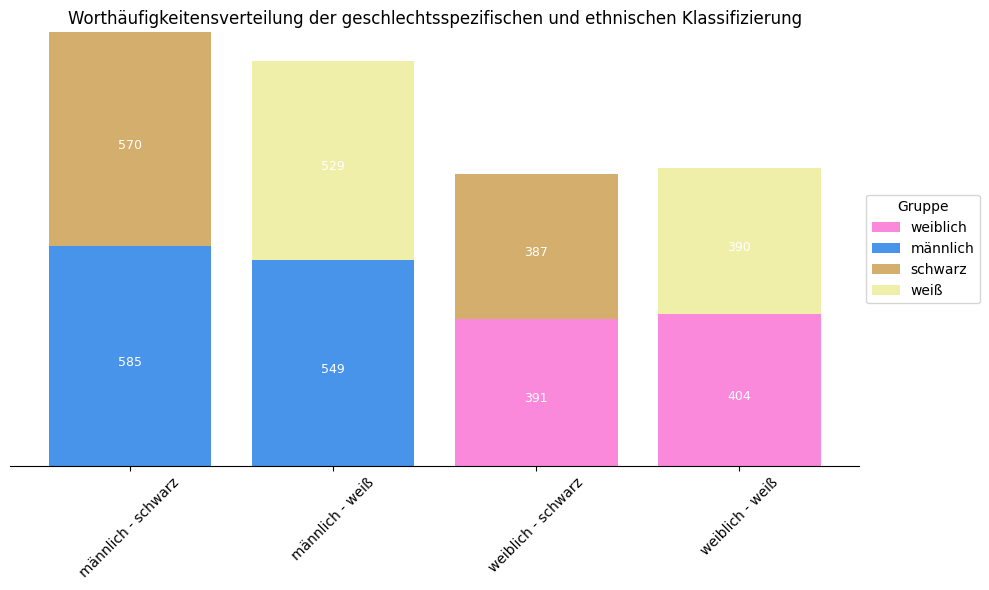

In [12]:
# Bestimmung der Anzahl der Worthäufigkeiten pro intersektionelle Gruppe und pro Klassifizierung
df_count = df.groupby('gender_race')[['count_female', 'count_male', 'count_black', 'count_white']].sum()
df_count['count_total'] = df_count['count_female'] + df_count['count_male'] + df_count['count_black'] + df_count['count_white'] # Gesamtsumme pro Klassifizierung
df_count = df_count.rename(columns={'count_female': 'weiblich','count_male': 'männlich','count_black': 'schwarz','count_white': 'weiß'}) # Umbenennung (für den Plot)
print(df_count)

# Plot: Worthäufigkeitensverteilung der geschlechtsspezifischen und ethnischen Klassifizierung
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#fa89dc', '#4994eb', '#d4ae6c', '#f0efaa']
bottom = [0, 0, 0, 0] # Für die Bezeichnungen der oberen gestabelten Balken
for idx, column in enumerate(['weiblich', 'männlich', 'schwarz', 'weiß']): # Werte innerhalb de Balken anzeigen
    values = df_count[column]
    bars = ax.bar(df_count.index, values, bottom=bottom, label=column, color=colors[idx])
    for i, bar in enumerate(bars): 
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                str(int(height)),
                ha='center', va='top',
                color='white', fontsize=9
            )

    bottom = [bottom[i] + values.iloc[i] for i in range(len(bottom))]
ax.yaxis.set_visible(False) # Y-Achse nicht anzeigen
ax.spines['left'].set_visible(False) # Kein Rahmen
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('')
plt.xlabel('')
plt.title('Worthäufigkeitensverteilung der geschlechtsspezifischen und ethnischen Klassifizierung')
plt.xticks(rotation=45)
ax.legend(title='Gruppe', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [13]:
# Bestimmung des Cohen's d Wert

cohens_d_ergebnisse_haeufigkeiten = []

# Bestimmung des Cohen's d Wert für die vorkommenden Geschlecht-Ethnie Kombinationen 
for i, row in df_evaluation.iterrows():
    g1 = df[df['gender_race'] == row['Gruppe 1']]['count_total'] # Gruppe 1
    g2 = df[df['gender_race'] == row['Gruppe 2']]['count_total'] # Gruppe 2
    d_haeufigkeiten = calculate_cohens_d(g1, g2)
    cohens_d_ergebnisse_haeufigkeiten.append(d_haeufigkeiten)
    print(f"Cohen's d für '{row['Gruppe 1']}' und '{row['Gruppe 2']}': {d_haeufigkeiten}")

# Neue Spalte zum bestehenden DataFrame hinzufügen
df_evaluation["Häufigkeit"] = cohens_d_ergebnisse_haeufigkeiten

Cohen's d für 'männlich - schwarz' und 'weiblich - weiß': 0.077
Cohen's d für 'männlich - weiß' und 'weiblich - weiß': 0.059
Cohen's d für 'männlich - schwarz' und 'weiblich - schwarz': 0.091
Cohen's d für 'männlich - weiß' und 'weiblich - schwarz': 0.072


### **Kookkurrenzmatrix**

In [14]:
''' 
# Kookkurrenzanalyse
''' 
#Funktion:       Bestimmung der Kookkurrenzhäufigkeiten
#Input:          target_words (Liste der Gruppenbegriffe für die die Kookkurrenzhäufigkeiten bestimmt werden soll)
#Output:         count_coocurrence (Kookkurrenzhäufigkeiten)
#Funktionsweise: Für jedes Zielwort werden die anderen Wörter in der Beschriftung geprüft und gezählt, wie oft das Zielwort gemeinsamm mit den Nicht-Zielworten im selben Satz vorkommt.
'''
def get_combined_coocurrence(target_words):
    count_coocurrence = Counter()
    for tokens in df['clean_caption']:
        for i, wort in enumerate(tokens):
            if wort in target_words:
                for j, partner in enumerate(tokens):
                    if i == j:
                        continue  
                    if partner not in target_words:
                        count_coocurrence[(wort, partner)] += 1
    return count_coocurrence

doc_freq = Counter() # Zählt wie häufig jedes Wort in den Texten vorkommt
for tokens in df['clean_caption']:
    doc_freq.update(set(tokens))

length_df = len(df)


 #  Zählung, wie oft jedes Wort in den Beschriftungen vorkommt
doc_freq = Counter()
for tokens in df['clean_caption']:
    doc_freq.update(set(tokens))

# Länge des Datensatzes
length_df = len(df)

''' 
#Funktion:       Bestimmung des PMI-Wertes für zwei Wörter w1 und w2
#Input:          w1 (Wort 1)
#                w1 (Wort 2)
#                count_coocurrence (Anzahl der Beschriftungen in denen w1 und w2 gemeinsam vorkommen)
#Output:         pmi (PMI-Wert)
#Funktionsweise: Basierend auf der PMI-Formel (log(p(w1,w2)/p(w1)p(w2))) wird der PMI-Wert bestimmt. 
'''
def get_pmi(w1, w2, count_coocurrence):
    p_w1 = doc_freq[w1] / length_df # p(w1)
    p_w2 = doc_freq[w2] / length_df # p(w2)
    p_w1w2 = count_coocurrence.get((w1, w2), 0) / length_df #p(w1,w2)
    if p_w1w2 == 0:
        return 0
    pmi = round(math.log2(p_w1w2 / (p_w1 * p_w2)), 2) # PMI-Wert
    return pmi

''' 
#Funktion:       Bestimmung der top 10 Kookkurrenzwörter 
#Input:          target_words (Liste der Gruppenbegriffe für die die top 10 Wörter bestimmt werden)
#Output:         top_words (Top 10 Wörter)
#Funktionsweise: Für die Zielwörter werden die Kookkurrenzhäufigkeiten mit allen Wortpaaren bestimmt. Für jedes Wortpaar wird der PMI bestimmt. Die 10 Wörter mit dem höchsten PMI Wert werden ausgegeben. 
'''
def get_coocurrence(target_words):
    cooc_counts = get_combined_coocurrence(target_words) # Für die Zielwörter werden die Kookkurrenzhäufigkeiten mit allen anderen Wörtern bestimmt
    pmi_scores = {}
    for (i, j) in cooc_counts.items(): # Für jedes Kookkurrenzpaat wird der PMI-Wert bestimmt 
        score_temp = get_pmi(i, j, cooc_counts)
        if j not in pmi_scores or score_temp > pmi_scores[j]: # Wenn Wort j mit mehreren Zielwörtern vorkommt, wird der jeweils höchste PMI-Wert gespeichert
            pmi_scores[j] = score_temp
    top_10_words = sorted(pmi_scores.items(), key=lambda x: -x[1])[:10] # Top 10 Kookkurrenzwörter mit dem höchsten PMI Wert werden gespeichert
    return(top_10_words)

# Anwendung der Funktion get_coocurrence auf die weiblich-weiß Begriffe
top_words_female_white = get_coocurrence(list_female_white_words)
# Anwendung der Funktion get_coocurrence auf die männlich-schwarz Begriffe
top_words_male_black = get_coocurrence(list_male_black_words)
# Anwendung der Funktion get_coocurrence auf die weiblich-schwarz Begriffe
top_words_female_black = get_coocurrence(list_female_black_words)
# Anwendung der Funktion get_coocurrence auf die männlich-weiß Begriffe
top_words_male_white = get_coocurrence(list_male_white_words)

# Top 10 Kookkurrenzwörter pro Gruppenkombination
print("Top 10 Kookkurrenzwörter der intersektionellen Gruppe weiblich-weiß:")
print(", ".join(f"({repr(wort)}, {score})" for wort, score in top_words_female_white))

print("\nTop 10 Kookkurrenzwörter der intersektionellen Gruppe männlich-schwarz:")
print(", ".join(f"({repr(wort)}, {score})" for wort, score in top_words_male_black))

print("\nTop 10 Kookkurrenzwörter der intersektionellen Gruppe weiblich-schwarz:")
print(", ".join(f"({repr(wort)}, {score})" for wort, score in top_words_female_black))

print("\nTop 10 Kookkurrenzwörter der intersektionellen Gruppe männlich-weiß:")
print(", ".join(f"({repr(wort)}, {score})" for wort, score in top_words_male_white))

'''

'\ndef get_coocurrence(target_words):\n    cooc_counts = get_combined_coocurrence(target_words) # Für die Zielwörter werden die Kookkurrenzhäufigkeiten mit allen anderen Wörtern bestimmt\n    pmi_scores = {}\n    for (i, j) in cooc_counts.items(): # Für jedes Kookkurrenzpaat wird der PMI-Wert bestimmt \n        score_temp = get_pmi(i, j, cooc_counts)\n        if j not in pmi_scores or score_temp > pmi_scores[j]: # Wenn Wort j mit mehreren Zielwörtern vorkommt, wird der jeweils höchste PMI-Wert gespeichert\n            pmi_scores[j] = score_temp\n    top_10_words = sorted(pmi_scores.items(), key=lambda x: -x[1])[:10] # Top 10 Kookkurrenzwörter mit dem höchsten PMI Wert werden gespeichert\n    return(top_10_words)\n\n# Anwendung der Funktion get_coocurrence auf die weiblich-weiß Begriffe\ntop_words_female_white = get_coocurrence(list_female_white_words)\n# Anwendung der Funktion get_coocurrence auf die männlich-schwarz Begriffe\ntop_words_male_black = get_coocurrence(list_male_black_word

In [18]:
# Kookkurrenzanalyse
''' 
Funktion:       Bestimmung der Kookkurrenzhäufigkeiten
Input:          target_words (Liste der Gruppenbegriffe für die die Kookkurrenzhäufigkeiten bestimmt werden soll)
Output:         count_coocurrence (Kookkurrenzhäufigkeiten)
Funktionsweise: Für jedes Zielwort werden die anderen Wörter in der Beschriftung geprüft und gezählt, wie oft das Zielwort gemeinsamm mit den Nicht-Zielworten im selben Satz vorkommt.
'''
def get_combined_coocurrence(target_words):
    count_coocurrence = Counter()
    
    for tokens in df['clean_caption']:
        for i, wort in enumerate(tokens):
            if wort in target_words:
                # Schleife über alle anderen Wörter im Satz
                for j, partner in enumerate(tokens):
                    if i == j:
                        continue  # kein Self-Pair
                    if partner not in target_words:
                        count_coocurrence[(wort, partner)] += 1
    return count_coocurrence

doc_freq = Counter() # Zählt wie häufig jedes Wort in den Texten vorkommt
for tokens in df['clean_caption']:
    doc_freq.update(set(tokens))

length_df = len(df)

''' 
Funktion:       Bestimmung des PMI-Wertes für zwei Wörter w1 und w2
Input:          w1 (Wort 1)
                w1 (Wort 2)
                count_coocurrence (Anzahl der Beschriftungen in denen w1 und w2 gemeinsam vorkommen)
Output:         pmi (PMI-Wert)
Funktionsweise: Basierend auf der PMI-Formel (log(p(w1,w2)/p(w1)p(w2))) wird der PMI-Wert bestimmt. 
'''
def pmi(w1, w2, count_coocurrence):
    p_w1 = doc_freq[w1] / length_df
    p_w2 = doc_freq[w2] / length_df
    p_w1w2 = count_coocurrence.get((w1, w2), 0) / length_df
    if p_w1w2 == 0:
        return 0
    pmi = round(math.log2(p_w1w2 / (p_w1 * p_w2)), 2)
    return pmi

''' 
Funktion:       Bestimmung der top 10 Kookkurrenzwörter 
Input:          zielwörter (Liste der Gruppenbegriffe für die die top 10 Wörter bestimmt werden)
Output:         top_words (Top 10 Wörter)
Funktionsweise: Für die Zielwörter werden die Kookkurrenzhäufigkeiten mit allen Wortpaaren
'''
def get_coocurrence(zielwörter):
    cooc_counts = get_combined_coocurrence(zielwörter)
    pmi_scores = {}
    for (zielwort, partner), count in cooc_counts.items():
        score = pmi(zielwort, partner, cooc_counts)
        if partner not in pmi_scores or score > pmi_scores[partner]:
            pmi_scores[partner] = score
    top_10_words = sorted(pmi_scores.items(), key=lambda x: -x[1])[:10]
    return(top_10_words)


top_words_female_white = get_coocurrence(list_female_white_words)
top_words_male_black = get_coocurrence(list_male_black_words)
top_words_female_black = get_coocurrence(list_female_black_words)
top_words_male_white = get_coocurrence(list_male_white_words)

# Top 10 Kookkurrenzwörter
print("Top 10 Kookkurrenzwörter der intersektionellen Gruppe weiblich-weiß:")
print(", ".join(f"({repr(wort)}, {score})" for wort, score in top_words_female_white))

print("\nTop 10 Kookkurrenzwörter der intersektionellen Gruppe männlich-schwarz:")
print(", ".join(f"({repr(wort)}, {score})" for wort, score in top_words_male_black))

print("\nTop 10 Kookkurrenzwörter der intersektionellen Gruppe weiblich-schwarz:")
print(", ".join(f"({repr(wort)}, {score})" for wort, score in top_words_female_black))

print("\nTop 10 Kookkurrenzwörter der intersektionellen Gruppe männlich-weiß:")
print(", ".join(f"({repr(wort)}, {score})" for wort, score in top_words_male_white))


Top 10 Kookkurrenzwörter der intersektionellen Gruppe weiblich-weiß:
('straw', 9.24), ('lab', 9.24), ('descends', 9.24), ('fingers', 8.82), ('attire', 8.82), ('urban', 8.24), ('follows', 8.24), ('dance', 8.24), ('band', 8.24), ('courtyard', 8.24)

Top 10 Kookkurrenzwörter der intersektionellen Gruppe männlich-schwarz:
('vert', 9.24), ('bleached', 9.24), ('propels', 9.24), ('tips', 8.24), ('style', 8.24), ('include', 8.01), ('dodges', 8.01), ('tackle', 8.01), ('wal', 8.01), ('mart', 8.01)

Top 10 Kookkurrenzwörter der intersektionellen Gruppe weiblich-schwarz:
('vert', 9.24), ('bleached', 9.24), ('propels', 9.24), ('lab', 9.24), ('descends', 9.24), ('fingers', 8.82), ('urban', 8.24), ('follows', 8.24), ('tips', 8.24), ('style', 8.24)

Top 10 Kookkurrenzwörter der intersektionellen Gruppe männlich-weiß:
('straw', 9.24), ('attire', 8.82), ('dance', 8.24), ('band', 8.24), ('courtyard', 8.24), ('redheaded', 8.24), ('brightlycolored', 8.24), ('fighting', 8.24), ('include', 8.01), ('dodges', 

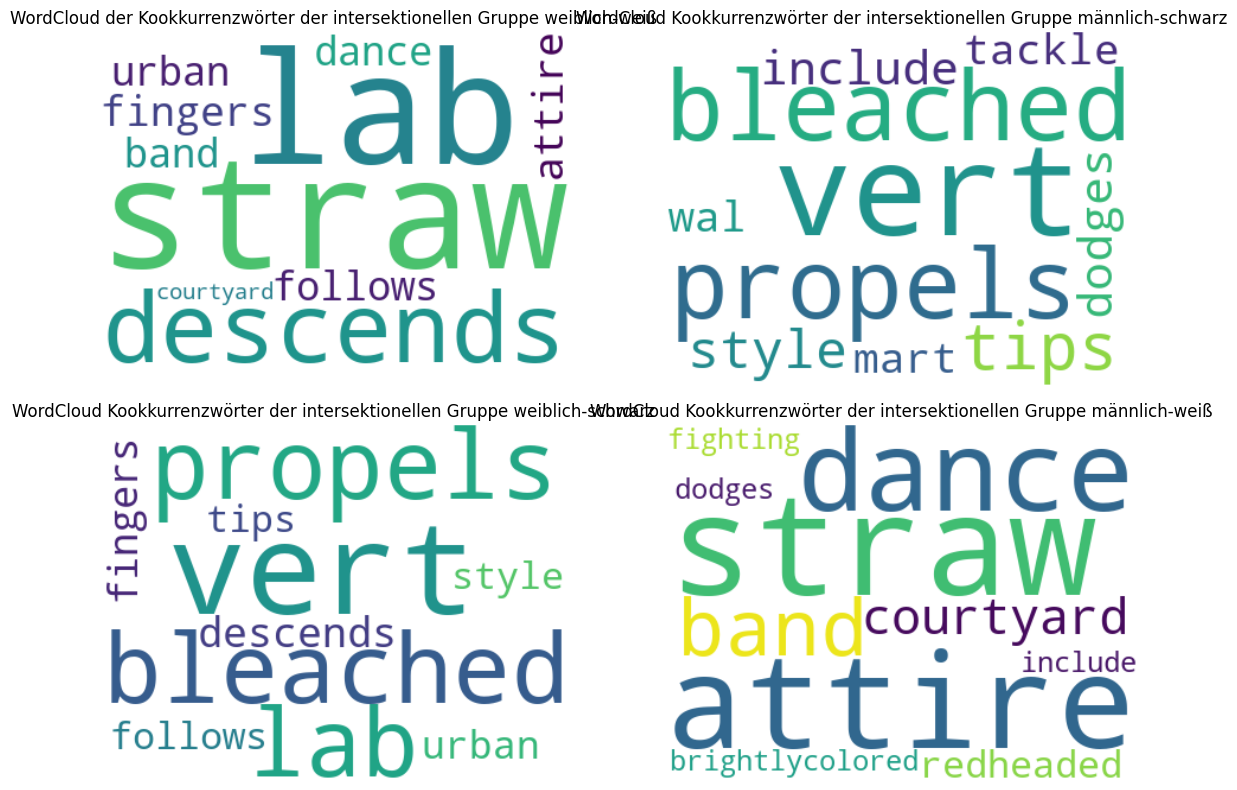

In [20]:
''' 
Funktion:       Erstellung einer Wortliste für die top 10 Kookkurrenzwörter
Input:          top_words (Top 10 Wörter)
Output:         wc (WordCloud)
Funktionsweise: Aus der Liste der Top 10 Wörter wird ein Dictonary erstellt, welches als Input für die WordCloud verwendet wird.
'''
def generate_wordcloud_plot(top_words):
    top_words_dict = {word: score for word, score in top_words}
    wc = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(top_words_dict)
    return wc


# Anwendung der Funktion generate_wordcloud_plot auf die weiblich-weiß Begriffe
wc_female_white = generate_wordcloud_plot(top_words_female_white)
# Anwendung der Funktion generate_wordcloud_plot auf die männlich-schwarz Begriffe
wc_male_black = generate_wordcloud_plot(top_words_male_black)
# Anwendung der Funktion get_coocugenerate_wordcloud_plotrrence auf die weiblich-schwarz Begriffe
wc_female_black = generate_wordcloud_plot(top_words_female_black)
# Anwendung der Funktion generate_wordcloud_plot auf die männlich-weiß Begriffe
wc_male_white = generate_wordcloud_plot(top_words_male_white)

# Plot: WordClouds der Kookkurrenzwörter der einzelnen Gruppen
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].imshow(wc_female_white, interpolation='bilinear')
axs[0, 0].set_title("WordCloud der Kookkurrenzwörter der intersektionellen Gruppe weiblich-weiß")
axs[0, 0].axis('off')
axs[0, 1].imshow(wc_male_black, interpolation='bilinear')
axs[0, 1].set_title("WordCloud Kookkurrenzwörter der intersektionellen Gruppe männlich-schwarz")
axs[0, 1].axis('off')
axs[1, 0].imshow(wc_female_black, interpolation='bilinear')
axs[1, 0].set_title("WordCloud Kookkurrenzwörter der intersektionellen Gruppe weiblich-schwarz")
axs[1, 0].axis('off')
axs[1, 1].imshow(wc_male_white, interpolation='bilinear')
axs[1, 1].set_title("WordCloud Kookkurrenzwörter der intersektionellen Gruppe männlich-weiß")
axs[1, 1].axis('off')
plt.tight_layout()
plt.show()

In [19]:
# Bestimmung des Cohen's d Wert

intersectional_groups_coocurence = {
    'weiblich - weiß': list_female_white_words,
    'männlich - schwarz': list_male_black_words,
    'männlich - weiß': list_male_white_words,
    'weiblich - schwarz': list_female_black_words
}

cohens_d_ergebnisse_kookkurrenz = []

# Bestimmung des Cohen's d Wert für die vorkommenden Geschlecht-Ethnie Kombinationen 
for gruppe1, gruppe2 in intersectional_groups:
    g1 = [pmi for _, pmi in get_coocurrence(intersectional_groups_coocurence[gruppe1])]
    g2 = [pmi for _, pmi in get_coocurrence(intersectional_groups_coocurence[gruppe2])]
    d_kookkurrenz = calculate_cohens_d(g1, g2)
    cohens_d_ergebnisse_kookkurrenz.append(round(d_kookkurrenz, 3))
    print(f"Cohen's d für '{gruppe1}' und '{gruppe2}': {d_kookkurrenz}")

# Neue Spalte zum bestehenden DataFrame hinzufügen
df_evaluation["Kookkurenz"] = cohens_d_ergebnisse_kookkurrenz

Cohen's d für 'männlich - schwarz' und 'weiblich - weiß': 0.444
Cohen's d für 'männlich - weiß' und 'weiblich - weiß': 0.714
Cohen's d für 'männlich - schwarz' und 'weiblich - schwarz': 0.698
Cohen's d für 'männlich - weiß' und 'weiblich - schwarz': 1.006


#### **Sentiment Analyse**

In [47]:
# Laden des Sentiment Analyse Modells
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert/distilbert-base-uncased-finetuned-sst-2-english")

# Anwendung der Sentiment Analyse auf die (unaufbereiteten) Beschriftungen
df["sentiment"] = df["caption"].apply(lambda x: sentiment_pipeline(x)[0]["label"])

# Quelle: HuggingFace. (2025). DistilBERT. Abgerufen am 04.07.2025 von https://github.com/huggingface/transformers/blob/main/docs/source/en/model doc/distilbert.md

Device set to use mps:0


          gender_race sentiment  count
0  männlich - schwarz  NEGATIVE    403
1  männlich - schwarz  POSITIVE    143
2     männlich - weiß  NEGATIVE    301
3     männlich - weiß  POSITIVE    210
4  weiblich - schwarz  NEGATIVE    235
5  weiblich - schwarz  POSITIVE    138
6     weiblich - weiß  NEGATIVE    181
7     weiblich - weiß  POSITIVE    199


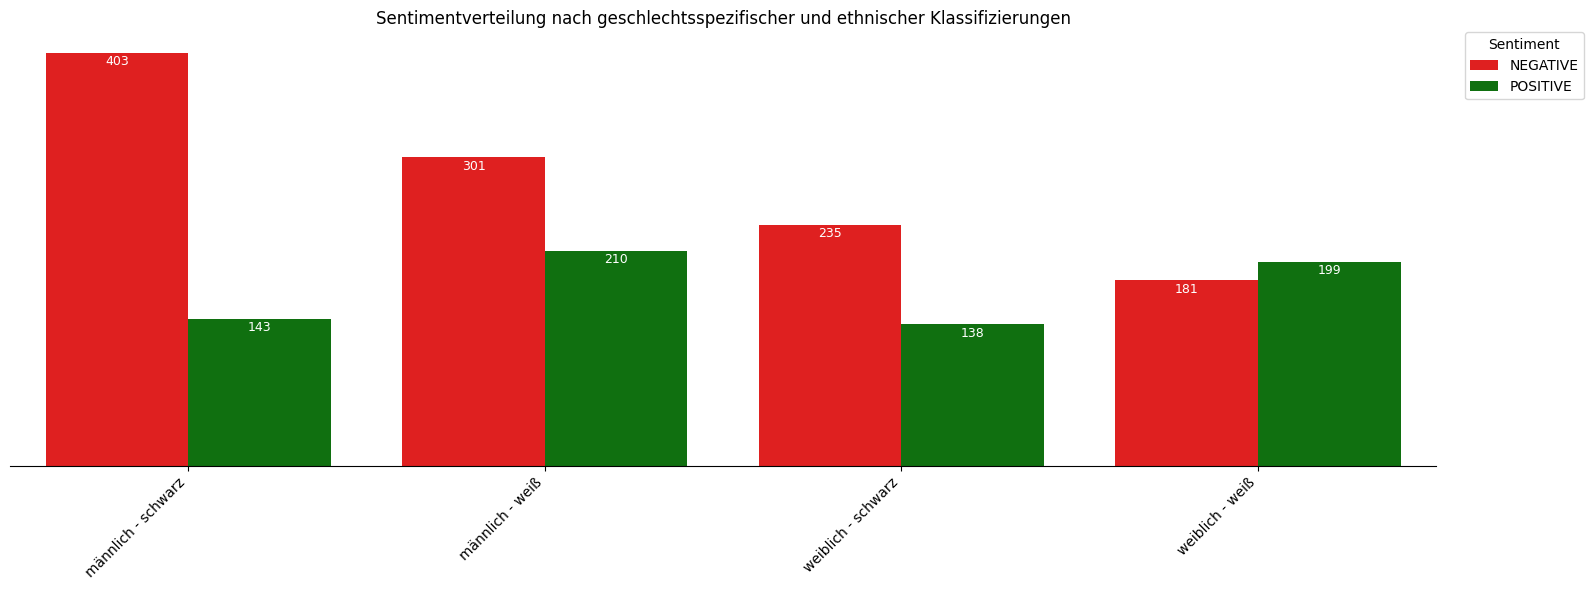

In [48]:
# Sentiment pro geschlechtsspezifischer und ethnischer Klasse
result_sentiment = df.groupby(['gender_race', 'sentiment']).size().reset_index(name='count')
print(result_sentiment)

# Plot: Sentimentverteilung nach geschlechtsspezifischer und ethnischer Klassifizierungen
color_palette = {'NEGATIVE': 'red','POSITIVE': 'green'}
plt.figure(figsize=(16, 6))
ax = sns.barplot(data=result_sentiment,x='gender_race',y='count',hue='sentiment', palette=color_palette)
plt.title('Sentimentverteilung nach geschlechtsspezifischer und ethnischer Klassifizierungen')
plt.xlabel('')
plt.ylabel('')
ax.yaxis.set_visible(False)  # Y-Achse nicht anzeigen
ax.spines['left'].set_visible(False)  # Kein Rahmen
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(range(len(result_sentiment['gender_race'].unique())))
ax.set_xticklabels(result_sentiment['gender_race'].unique(), rotation=45, ha='right')
plt.xticks(rotation=45)
plt.legend(title='Sentiment',bbox_to_anchor=(1.02, 1),loc='upper left',borderaxespad=0) # Legende auf die rechten Seite der Grafik setzten
for container in ax.containers: # Werte innerhalb des Balkens anzeigen
    ax.bar_label(container, label_type='edge', padding=-11, fontsize=9, color='white')
plt.tight_layout()
plt.show()

In [49]:
# Sentiment Ergebnis in numerischen Datentyp ändern (Für die Bestimmung des Cohen's d Werts)
label_map = {
    'NEGATIVE': -1,
    'NEUTRAL': 0,
    'POSITIVE': 1
}
df['sentiment_score'] = df['sentiment'].map(label_map)

In [50]:
# Bestimmung des Cohen's d Wert

cohens_d_ergebnisse_sentiment = []

# Bestimmung des Cohen's d Wert für die vorkommenden Geschlecht-Ethnie Kombinationen 
for gruppe1, gruppe2 in intersectional_groups:
    g1 = df[df['gender_race'] == gruppe1]['sentiment_score']
    g2 = df[df['gender_race'] == gruppe2]['sentiment_score']
    d_sentiment = calculate_cohens_d(g1, g2)
    cohens_d_ergebnisse_sentiment.append(round(d_sentiment, 3))
    print(f"Cohen's d für '{gruppe1}' und '{gruppe2}': {d_sentiment}")

# Neue Spalte zum bestehenden DataFrame hinzufügen
df_evaluation["Sentiment"] = cohens_d_ergebnisse_sentiment

Cohen's d für 'männlich - schwarz' und 'weiblich - weiß': 0.562
Cohen's d für 'männlich - weiß' und 'weiblich - weiß': 0.227
Cohen's d für 'männlich - schwarz' und 'weiblich - schwarz': 0.236
Cohen's d für 'männlich - weiß' und 'weiblich - schwarz': 0.084


### **WEAT**

In [51]:
# Laden des WEAT Models
glove_model = api.load("glove-wiki-gigaword-300")
wefe_model = WordEmbeddingModel(glove_model, "glove-wiki-gigaword-300") # Umwandlung in WEFE Format

# Quelle: de Ciencias de la Computaci´on Universidad de Chile, D. (2025). Bias Measurement. Abgerufen am 01.08.2025 von https://github.com/dccuchile/wefe/blob/develop/docs/user guide/measurement user guide.rst

In [52]:
# Bestimmung der in den Beschriftung vorkommenden Adjektive 
nlp = spacy.load("en_core_web_sm")

list_adjective = set()

for text in df['clean_caption_string']:
    doc = nlp(text)
    list_adjective.update([token.text for token in doc if token.pos_ == 'ADJ'])

with open("adjektive.txt", "w", encoding="utf-8") as f:
    for adj in sorted(list_adjective):
        f.write(adj + ", ")

In [53]:
# Attributslisten definieren

# Basierend auf die identifizierten Adjektiv-Begriffe werden zwei Attributsgruppen (positiv, negatvi) festgelegt.

attribute_set_1 = [
    "alert", "athletic", "balanced", "beautiful", "bright", "cheerful",
    "clear", "colorful", "elaborate", "fair", "fancy", "fast", "floral", 
    "fluffy", "formal", "free", "funny", "golden", "grand", "grassy", "happy",
    "high", "hot", "light", "modern", "muscular", "pretty", "pro", "ready",
    "robust", "rosy", "smooth", "soft", "sunny", "tall", "traditional",
    "tropical", "uplifted", "young", "younger"
]

attribute_set_2 = [
    "aged", "asleep", "back", "bad", "bald", "bland", "blurry",
    "cheap", "cloudy", "coarse", "cold", "confused", "crowded",
    "dark", "dry", "fallen", "fuzzy", "handicapped", "hard", 
    "homeless", "muddy", "murky", "obscure", "old", "older", 
    "oldfashioned", "poor", "rough", "shallow", "short", "silly", 
    "skimpy", "skinny", "small", "smaller", "steep", "strange", 
    "thin", "tough", "weird", "wet"
]

# Bestimmung der Attributsgruppen: OpenAI (2025)

In [54]:
# Ziellisten definieren

target_set_1_1 = list_male_black_words
target_set_2_1 = list_female_white_words

target_set_1_2 = list_male_black_words
target_set_2_2 = list_female_black_words

target_set_1_3 = list_male_white_words
target_set_2_3 = list_female_white_words

target_set_1_4 = list_male_white_words
target_set_2_4 = list_female_black_words

In [55]:
# WEAT berechnen

weat = WEAT()

query_1 = Query(
    target_sets=[target_set_1_1, target_set_2_1],
    attribute_sets=[attribute_set_1, attribute_set_2],
)
query_2 = Query(
    target_sets=[target_set_1_2, target_set_2_2],
    attribute_sets=[attribute_set_1, attribute_set_2],
)
query_3 = Query(
    target_sets=[target_set_1_3, target_set_2_3],
    attribute_sets=[attribute_set_1, attribute_set_2],
)
query_4 = Query(
    target_sets=[target_set_1_4, target_set_2_4],
    attribute_sets=[attribute_set_1, attribute_set_2],
)

In [56]:
intersectional_groups_weat = [
    ("männlich - schwarz", "weiblich - weiß", query_1),
    ("männlich - schwarz", "weiblich - schwarz", query_2),
    ("männlich - weiß", "weiblich - weiß", query_3),
    ("männlich - weiß", "weiblich - schwarz", query_4),
]

cohens_d_ergebnisse_weat = []

# Bestimmung des Cohen's d Wert für die vorkommenden Geschlecht-Ethnie Kombinationen 
for gruppe1, gruppe2, query in intersectional_groups_weat:
    result = weat.run_query(query, model=wefe_model, permutations=10000)
    effect_size = result["effect_size"]
    cohens_d_ergebnisse_weat.append(round(effect_size, 3))
    print(f"Effektstärke für Zielgruppen {gruppe1} und {gruppe2}: {result['effect_size']:.3f}")

# Neue Spalte zum bestehenden DataFrame hinzufügen
df_evaluation["WEAT"] = cohens_d_ergebnisse_weat

Effektstärke für Zielgruppen männlich - schwarz und weiblich - weiß: -0.310
Effektstärke für Zielgruppen männlich - schwarz und weiblich - schwarz: -0.357
Effektstärke für Zielgruppen männlich - weiß und weiblich - weiß: -0.368
Effektstärke für Zielgruppen männlich - weiß und weiblich - schwarz: -0.415


### **Vergleich der Cohen's d bzw. Effektstärke**

In [57]:
df_evaluation

,Gruppe 1,Gruppe 2,Häufigkeit,Kookkurenz,Sentiment,WEAT
0,männlich - schwarz,weiblich - weiß,0.077,0,0.562,-0.310
1,männlich - weiß,weiblich - weiß,0.059,0,0.227,-0.357
2,männlich - schwarz,weiblich - schwarz,0.091,0,0.236,-0.368
3,männlich - weiß,weiblich - schwarz,0.072,0,0.084,-0.415


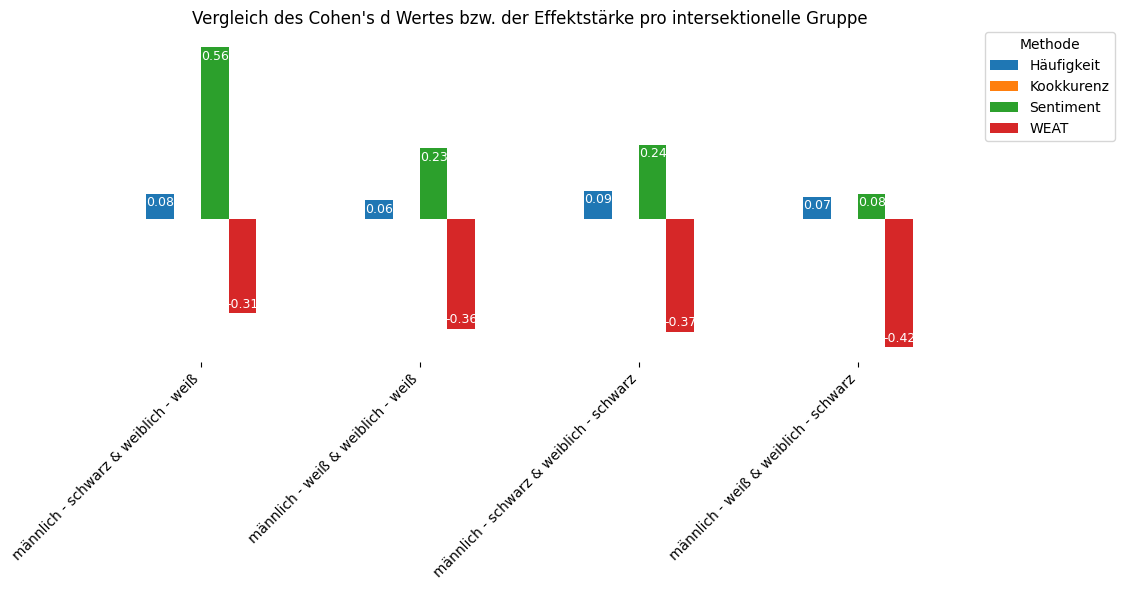

In [58]:
# Plot: Vergleich des Cohen's d Wertes bzw. der Effektstärke pro intersektionelle Gruppe
df_evaluation['Gruppenpaar'] = df_evaluation['Gruppe 1'] + ' & ' + df_evaluation['Gruppe 2']
df_plot = df_evaluation[['Gruppenpaar', "Häufigkeit", "Kookkurenz", "Sentiment", 'WEAT']].copy()
df_plot[["Häufigkeit", "Kookkurenz", "Sentiment", 'WEAT']] = df_plot[["Häufigkeit", "Kookkurenz", "Sentiment", 'WEAT']].round(2)
df_plot.set_index('Gruppenpaar').plot(kind='bar', figsize=(10,6))
plt.ylabel('')
plt.xlabel('')
plt.title("Vergleich des Cohen's d Wertes bzw. der Effektstärke pro intersektionelle Gruppe")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
for spine in plt.gca().spines.values(): # Kein Rahmen
    spine.set_visible(False)
ax = plt.gca()
ax.yaxis.set_visible(False)  # Y-Achse ausblenden 
plt.legend(title='Methode',bbox_to_anchor=(1.02, 1),loc='upper left',borderaxespad=0) # Legende auf die rechten Seite der Grafik setzten
for container in ax.containers: # Werte innerhalb des Balkens anzeigen
    ax.bar_label(container, label_type='edge', padding=-11, fontsize=9, color='white')
plt.show()

***
***